# MA 544: Programming Assignment - 2
---


In [61]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix

### Question 1: Visualization of Sparse Matrices
---
Create the sparse COO representation of the adjacency matrix of the following graph. One need not find the 2-dimensional representation for doing so. Find its CSR representation using appropriate Python function. Visualize this matrix by using spy() function. Refer to the notebook on sparse Matrices and check [the SciPy documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html#scipy.sparse.coo_matrix). 

<img src="https://in.mathworks.com/help/examples/matlab/win64/buckydem_02.png" width="50%" />

[Image source: Mathworks](https://in.mathworks.com/help/examples/matlab/win64/buckydem_02.png)

VALUES: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
COL_IND: [ 1  4  5  2 10  3 15  4 20 25  6  9  7 29  8 41  9 37 11 11 14 12 13 36
 14 32 16 16 19 17 18 19 52 21 21 24 22 23 51 24 47 26 26 29 27 28 46 29
 42 31 34 53 32 33 34 35 55 36 39 37 38 39 40 56 46 49 47 48 49 50 58 51
 54 52 53 54 59 56 59 57 58 59]
ROW_PTR: [ 0  3  5  7  9 10 12 14 16 18 19 21 22 24 26 27 29 30 31 33 34 36 37 39
 41 42 44 45 47 49 49 52 53 54 56 57 59 60 61 63 64 64 64 64 64 64 66 67
 68 70 71 73 74 75 76 77 79 80 81 82 82]


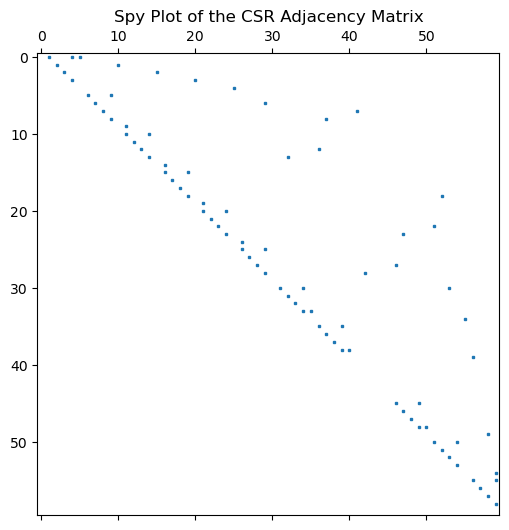

In [63]:
# Define the graph from the given image (assumed structure)
edges = [
    (1,2), (1,5), (1,6), (2,11), (2,3), (3,16), (3,4), (4,21), (4,5), (5,26), (6,7), (6,10),
    (7,8), (7,30), (8,9), (8,42), (9,10), (9,38), (10,12), (11,12), (11,15), (12,13), 
    (13,14), (13,37), (14,15), (14,33), (15,17), (16,20), (16,17), (17,18), (18,19), (19,20),
    (19,53), (20,22), (21,22), (21,25), (22,23), (23,24), (23,52), (24,25), (24,48), (25,27), 
    (26,27), (26,30), (27,28), (28,29), (28,47), (29,30), (29,43), (31,32), (31,35), (31,54),
    (32,33), (33,34), (34,35), (34,36), (35,56), (36,37), (36,40), (37,38), (38,39), (39,40),
    (39,41), (40,57), (46,47), (46,50), (47,48), (48,49), (49,50), (49, 51), (50,59), (51,52),
    (51,55), (52,53), (53,54), (54,55), (55,60), (56,57), (56,60), (57,58), (58,59), (59,60)
]
# Convert edges to zero-based index
edges = [(u-1, v-1) for u, v in edges]

# Create adjacency matrix in COO format
num_nodes = 60
row, col = zip(*edges)
data = np.ones(len(edges))

adj_coo = coo_matrix((data, (row, col)), shape=(num_nodes, num_nodes))

# Convert COO to CSR format
adj_csr = adj_coo.tocsr()
print("VALUES:", adj_csr.data)
print("COL_IND:", adj_csr.indices)
print("ROW_PTR:", adj_csr.indptr)

# Visualize the matrix using spy()
plt.figure(figsize=(6,6))
plt.spy(adj_csr, markersize=2)
plt.title("Spy Plot of the CSR Adjacency Matrix")
plt.show()


### Question 2: Page Ranking
---
Visit the SNAP networks database to find the [Berkley-Stanford Webgraph from 2002](https://snap.stanford.edu/data/web-BerkStan.html). This dataset gives the hyperlink structure of $685230$ webpages having a total of $7600595$ hyperlinks. 

A. Download the datafile and read the data to create a link matrix $Q$ in the DoK format. 

B. Use the optimized page-ranking algorithm with damping factor values $\alpha=0.85$ and $\alpha=0.95$ to find the page-ranking vector $\mathbf{r}$ while maintaining the same tolerance level for convergence. Report on the time it takes to perform these calculations. 

C. Find the indices of the $10$ highest ranking web-pages in decreasing order for the two runs. 

D. Now use a personalization vector that gives equal non-zero probability to pages with prime indices otherwise zero. Find the indices of the $10$ highest ranking web-pages. Use  only $\alpha=0.85$ in this case.

In [65]:
# Step A: Load web-BerkStan.txt.gz and Construct Adjacency Matrix
import gzip
from scipy.sparse import dok_matrix, coo_matrix

# Define file path
file_path = "web-BerkStan.txt.gz"

# Read file efficiently line-by-line and store edges in numpy arrays
edges = []
max_index = 0

with gzip.open(file_path, 'rt') as file:
    for line in file:
        if line.startswith('#'):  # Skip comments
            continue
        source, target = map(int, line.strip().split())
        edges.append((source, target))
        max_index = max(max_index, source, target)

# Convert list of edges to numpy arrays for faster processing
edges = np.array(edges, dtype=np.int32)

# Create a sparse COO matrix first (faster than direct DoK insertions)
row, col = edges[:, 0], edges[:, 1]
data = np.ones(len(edges), dtype=np.float32)

# Create the adjacency matrix in COO format, then convert to DoK
Q = coo_matrix((data, (row, col)), shape=(max_index + 1, max_index + 1)).todok()

# Display matrix information
print(f"Matrix size: {Q.shape}, Non-zero entries: {Q.nnz}")


Matrix size: (685231, 685231), Non-zero entries: 7600595


In [66]:
#Step B
import time

# Number of webpages (nodes)
n = Q.shape[0]

# Damping factors
alphas = [0.85, 0.95]
tolerance = 1e-6  # Convergence tolerance
max_iterations = 100  # Safety limit

# Convert DoK matrix to Compressed Sparse Column (CSC) for faster matrix operations
Q = Q.tocsc()

# Store results
results = {}

for alpha in alphas:
    print(f"\nComputing PageRank for α = {alpha}...")
    
    # Initialize uniform PageRank vector
    r = np.ones(n) / n
    
    # Start timing
    start_time = time.time()
    
    # Power Iteration method
    for iteration in range(max_iterations):
        r_new = alpha * Q @ r + (1 - alpha) / n  # PageRank update
        diff = np.linalg.norm(r_new - r, ord=1)  # Compute L1 norm difference
        
        # Check for convergence
        if diff < tolerance:
            break
        r = r_new

    # End timing
    elapsed_time = time.time() - start_time

    # Store results
    results[alpha] = {
        "page_rank_vector": r,
        "iterations": iteration + 1,
        "time_taken": elapsed_time
    }

    print(f"Converged in {iteration + 1} iterations, Time taken: {elapsed_time:.4f} seconds")

# Display final results
for alpha in alphas:
    print(f"\nPageRank results for α = {alpha}:")
    print(f"  Iterations: {results[alpha]['iterations']}")
    print(f"  Time taken: {results[alpha]['time_taken']:.4f} seconds")



Computing PageRank for α = 0.85...
Converged in 100 iterations, Time taken: 4.9783 seconds

Computing PageRank for α = 0.95...
Converged in 100 iterations, Time taken: 4.7098 seconds

PageRank results for α = 0.85:
  Iterations: 100
  Time taken: 4.9783 seconds

PageRank results for α = 0.95:
  Iterations: 100
  Time taken: 4.7098 seconds


In [67]:
#Step C: Find Top 10 Highest-Ranked Pages

# Function to find top 10 indices
def top_10_pages(page_rank_vector):
    return np.argsort(page_rank_vector)[::-1][:10]  # Sort in decreasing order

# Get top 10 pages for α = 0.85
top_10_alpha_85 = top_10_pages(results[0.85]["page_rank_vector"])

# Get top 10 pages for α = 0.95
top_10_alpha_95 = top_10_pages(results[0.95]["page_rank_vector"])

# Display results
print("\nTop 10 Web Pages for α = 0.85:")
print(top_10_alpha_85)

print("\nTop 10 Web Pages for α = 0.95:")
print(top_10_alpha_95)


Top 10 Web Pages for α = 0.85:
[518734 518674 518670 518668 518666 518664 518662 518660 518658 518656]

Top 10 Web Pages for α = 0.95:
[518524 518596 518594 518592 518464 518590 518462 518516 518588 518460]


In [68]:
#Step D: Personalized PageRank with Prime Indices

# Function to check if a number is prime
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n ** 0.5) + 1):
        if n % i == 0:
            return False
    return True

# Create the personalization vector p (non-zero only for prime indices)
p = np.zeros(n)

# Get prime indices
prime_indices = [i for i in range(n) if is_prime(i)]
p[prime_indices] = 1.0

# Normalize p so it sums to 1
p = p / np.sum(p)

# Use α = 0.85
alpha = 0.85
tolerance = 1e-6
max_iterations = 100

# Initialize PageRank vector
r = np.ones(n) / n

# Convert Q to CSC format for faster computation
Q = Q.tocsc()

# Start timing
start_time = time.time()

# Power Iteration with personalized PageRank
for iteration in range(max_iterations):
    r_new = alpha * Q @ r + (1 - alpha) * p  # Personalized update
    diff = np.linalg.norm(r_new - r, ord=1)  # Compute L1 norm difference
    
    # Check for convergence
    if diff < tolerance:
        break
    r = r_new

# End timing
elapsed_time = time.time() - start_time

# Get top 10 ranked pages
top_10_personalized = np.argsort(r)[::-1][:10]

# Display results
print(f"\nPersonalized PageRank with α = {alpha}:")
print(f"  Converged in {iteration + 1} iterations")
print(f"  Time taken: {elapsed_time:.4f} seconds")
print("\nTop 10 Web Pages with Personalized PageRank:")
print(top_10_personalized)



Personalized PageRank with α = 0.85:
  Converged in 100 iterations
  Time taken: 4.9952 seconds

Top 10 Web Pages with Personalized PageRank:
[518524 518596 518594 518592 518464 518590 518462 518516 518588 518460]


### Question 3: Clustering
---
Pick up a dataset of your choice for clustering ([UCI dataset](https://archive.ics.uci.edu/datasets)). Apply various clustering algorithms (including at least k-means and spectral clustering) to this dataset and explain your observations by using insightful plots or other some other metrics. Compare these algorithms based on some metric such as silhouette score, adjusted rand index etc.

- Read [this blog](https://machinelearningmastery.com/clustering-algorithms-with-python/) for some help.
- You can also refer to the codes and discusion [for this Kaggle dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data).

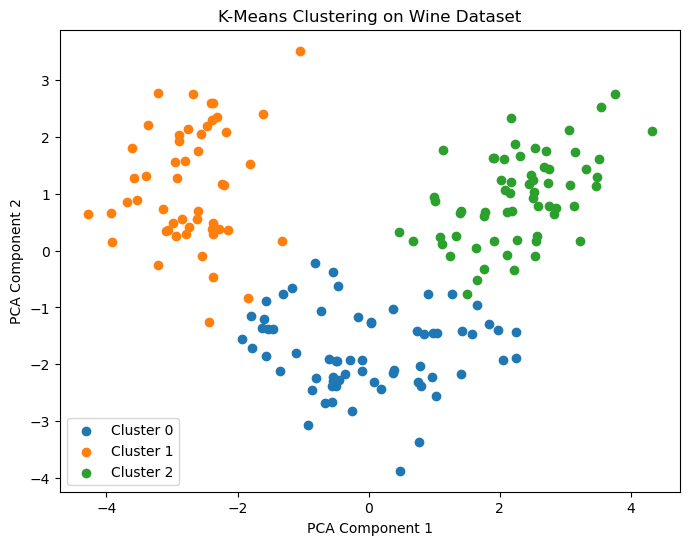

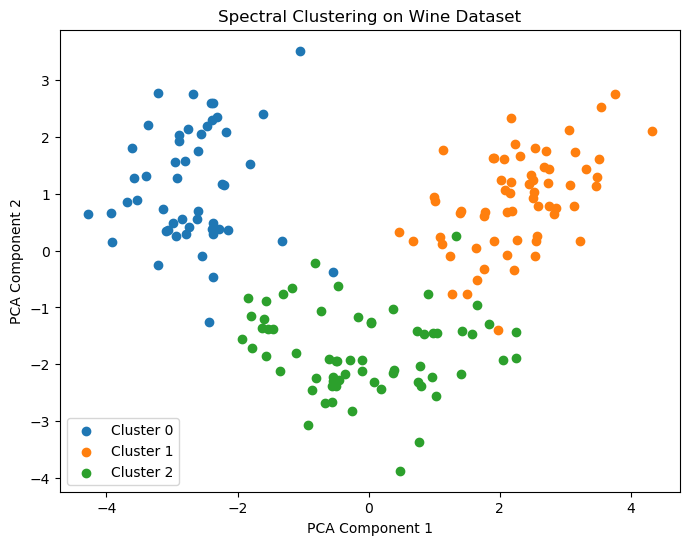

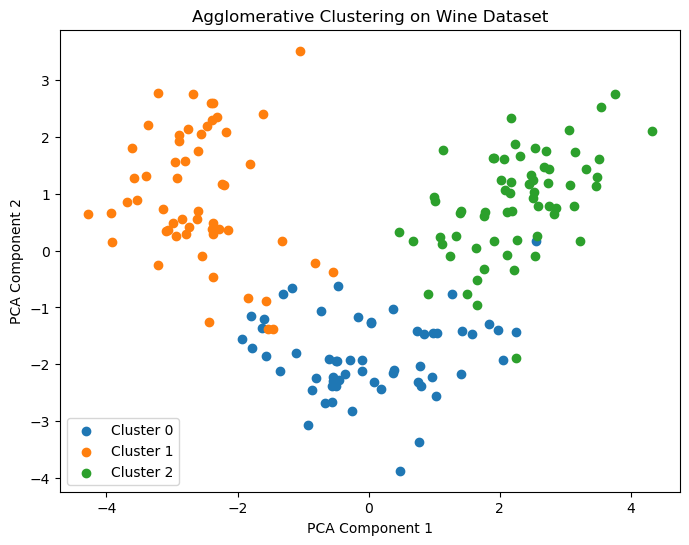

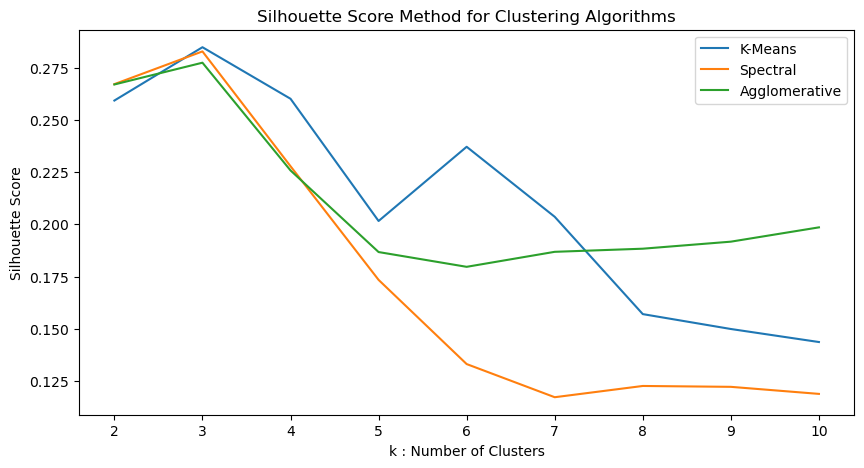

In [70]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from numpy import where
from sklearn.metrics import silhouette_score
import seaborn as sns

# Define the file path (update path if necessary)
wine_data = "wine/wine.data"

# Load dataset
df = pd.read_csv(wine_data, header=None)

# Separate features and target variable
X = df.iloc[:, 1:].values  # Features (excluding the first column)
y = df.iloc[:, 0].values  # Actual class labels

# Standardize the features (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

############### Apply Clustering Algorithms ###############

#### K-means Clustering ####

#define the model
modelk_means = KMeans(n_clusters=3, random_state=42)  # 3 clusters since Wine dataset has 3 classes

#fit the model
modelk_means.fit(X_scaled)

# Assign a cluster to each sample
yhat = model.predict(X_scaled)

# Retrieve unique clusters
clusters = np.unique(yhat)

# Create scatter plot for samples from each cluster using PCA to reduce dimensionality for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Reduce dimensions to 2D for plotting

plt.figure(figsize=(8, 6))
for cluster in clusters:
    row_ix = where(yhat == cluster)
    plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], label=f"Cluster {cluster}")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.title("K-Means Clustering on Wine Dataset")
plt.show()

#### Spectral Clustering ####

# define the model
modelspectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)

# Fit the model & assign clusters to each sample
syhat = modelspectral.fit_predict(X_scaled)

# Retrieve unique clusters
clusters = np.unique(syhat)

# Use PCA for visualization (since data is high-dimensional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Reduce features to 2D

# Scatter plot for clusters
plt.figure(figsize=(8, 6))
for cluster in clusters:
    row_ix = where(syhat == cluster)
    plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], label=f"Cluster {cluster}")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.title("Spectral Clustering on Wine Dataset")
plt.show()

#### Agglomerative Clustering ####

# define the model
modelagg = AgglomerativeClustering(n_clusters=3)

# Fit the model & assign clusters to each sample
ayhat = modelagg.fit_predict(X_scaled)

# Retrieve unique clusters
clusters = np.unique(ayhat)

# Use PCA for visualization (since data is high-dimensional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Reduce features to 2D

# Scatter plot for clusters
plt.figure(figsize=(8, 6))
for cluster in clusters:
    row_ix = where(ayhat == cluster)
    plt.scatter(X_pca[row_ix, 0], X_pca[row_ix, 1], label=f"Cluster {cluster}")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.title("Agglomerative Clustering on Wine Dataset")
plt.show()


############### Compare Clustering Algorithms ###############

#### Silhouette Score ####
# Define range of k values for clustering evaluation
kmax = 10  # Test cluster numbers from 2 to kmax

# Store silhouette scores for each algorithm
silhouette_scores = {"K-Means": [], "Spectral": [], "Agglomerative": []}
k_values = list(range(2, kmax + 1))  # Cluster numbers from 2 to kmax

# Compute silhouette scores for each algorithm
for k in k_values:
    # K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    silhouette_scores["K-Means"].append(silhouette_score(X_scaled, kmeans.labels_, metric="euclidean"))

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42).fit(X_scaled)
    silhouette_scores["Spectral"].append(silhouette_score(X_scaled, spectral.labels_, metric="euclidean"))

    # Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=k).fit(X_scaled)
    silhouette_scores["Agglomerative"].append(silhouette_score(X_scaled, agglo.labels_, metric="euclidean"))

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
for method, scores in silhouette_scores.items():
    sns.lineplot(x=k_values, y=scores, label=method)

plt.xlabel("k : Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method for Clustering Algorithms")
plt.legend()
plt.show()